In [358]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.discriminant_analysis import StandardScaler
from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import datasets


# Projet ANDO

## Projection Orthogonale

**Définition** :

Soit $\mathcal{E}$ un espace vecteuriel de dimension $p$. Si $\mathcal{D}$ est une droite vecteurielle engendrée par le vecteur $\vec{a}$ qui passe par un point $Q$ de $\mathbb{R}^p$, l'ensemble des vecteurs orthogonaux à $\mathcal{D}$ est un hyperplan appelé hyperplan normal à $\mathcal{D}$ et défini par : 

$$
\mathcal{D}^{\perp} =  \left\{ \vec{h} \in \mathbb{R}^p \mid (\vec{h}\cdot \vec{a}) = 0 \right\}
$$


Si $x$ est un point arbitraire de $\mathbb{R}^p$ et si on note $\vec{x}$ le vecteur associé qui va de $Q$ à ce point, on peut toujours le décomposer de la façon suivante :

$$
\vec{x} = \vec{x}_{\mathcal{D}} + \vec{x}_{\perp}
\text{ avec }
\vec{x}_{\mathcal{D}} = \frac{(\vec{x} \cdot \vec{a})}{\|a\|^2}\vec{a}
$$

Si on note $x_{\mathcal{D}}$ la projection du point sur la droite $\mathcal{D}$ et si on note $x_i$ la ième composante du point $x$, on obtient alors les coordonnées du point $x_{\mathcal{D}}$:

$$
\forall i \in [1;p], x_{\mathcal{D}_i} =  Q_{i} + \frac{\sum_{k=1}^{p} (x_{k} - Q_{k}) * a_{k}}{\|a\|^2} * a_{i}
$$

Pour avoir la distance entre le point $x$ et la droite $\mathcal{D}$, on a besoin de:

$$
\|\vec{x}_{\perp} \| = \|(x_1 - x_{\mathcal{D}_1},\  x_2 - x_{\mathcal{D}_2}, \ ..., \ x_p - x_{\mathcal{D}_p}) \|
$$

Dans la suite de ce document, on choisira de représenter une droite dans $\mathbb{R}^p$ par un de ses vecteurs directeurs unitaires, noté $\vec{u}$.

In [359]:
# Fonction pour la projection orthogonale d'un point sur une droite
# x: point à projeter
# u: vecteur directeur unitaire de la droite
# q: point de la droite
# retourne la projection orthogonale de x sur la droite
def projection_orthogonale(x, u, q):
    return np.dot(x - q, u) * u + q

# Fonction pour calculer la distance entre un point et sa projection orthogonale sur une droite
# x: un point de l'espace
# u: vecteur directeur unitaire de la droite
# q: point de la droite
# retourne la distance entre x et sa projection orthogonale sur la droite
def distance_projection(x, u, q):
    projection = projection_orthogonale(x, u, q)
    return np.linalg.norm(x - projection)

In [360]:
class Point():
    def __init__(self, coordonnées: np.array):
        self.coordonnées = coordonnées

    def __repr__(self):
        return f"Point({self.coordonnées})"
    
    def dim(self):
        return self.coordonnées.shape[0]
    
class Droite():
    def __init__(self, point: Point, vecteur: np.array):
        if (point.dim() != vecteur.shape[0]):
            raise Exception("Le vecteur doit avoir la même dimension que le point", point.dim(), vecteur.shape[0])
        self.point = point
        self.vecteur = vecteur/np.linalg.norm(vecteur)

    def __repr__(self):
        return f"Droite(Passe par le point {self.point}, vecteur directeur {self.vecteur})"

    def projection_orthogonale(self, point: Point):
        if (point.dim() != self.vecteur.shape[0]):
           raise Exception("Le point doit avoir la même dimension que le vecteur directeur,", point.dim(), self.vecteur.shape[0])
        return projection_orthogonale(point.coordonnées, self.vecteur, self.point.coordonnées)

    def distance_projection(self, point: Point):
        if (point.dim() != self.vecteur.shape[0]):
            raise Exception("Le point doit avoir la même dimension que le vecteur directeur,", point.dim(), self.vecteur.shape[0])
        return distance_projection(point.coordonnées, self.vecteur, self.point.coordonnées)
    
    def afficher(self, ax):
        # Définir deux points pour tracer la droite
        point1 = self.point.coordonnées
        point2 = self.point.coordonnées + self.vecteur

        # Tracer la droite
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], label=f"Droite {self.point} - {point2}")
    

In [361]:
# Fonction pour afficher la projection orthogonale d'un point sur une droite
# x: point à projeter
# droite: droite de la projection 
def plot_projection_distance(x: Point, D: Droite):
    # Calculer la projection orthogonale
    projection = D.projection_orthogonale(x)
    
    # Créer un vecteur pour représenter la droite
    t = np.linspace(0, 5, 100)
    line = np.outer(t, D.vecteur) + D.point.coordonnées
    
    # Créer le graphique
    plt.figure(figsize=(8, 8))
    
    # Tracer la droite
    plt.plot(line[:, 0], line[:, 1], label='Droite D')
    
    # Tracer le point x
    plt.scatter(x.coordonnées[0], x.coordonnées[1], color='red', label='Point x')
    
    # Tracer la projection orthogonale
    plt.scatter(projection[0], projection[1], color='green', label='Projection orthogonale')
    
    # Tracer la ligne de distance
    plt.plot([x.coordonnées[0], projection[0]], [x.coordonnées[1], projection[1]], linestyle='--', color='blue', label='Distance')
    
    # Ajouter des étiquettes et une légende
    plt.text(x.coordonnées[0] + 0.2, x.coordonnées[1] + 0.2, 'point x', color='red')
    plt.text(projection[0] + 0.2, projection[1] - 0.2, 'Projection', color='green')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()
    plt.axis('equal')
    plt.title('Projection orthogonale et distance entre un point et une droite')
    
    # Afficher le graphique
    plt.show()

#nbconvert

## Exemple

Dans l'exemple qui suit, nous allons travailler dans $\mathbb{R}^2$ et:
- $x$ est le point $(2, 3)$
- $D1$ est la droite passant par le point $(0, 0)$ et de vecteur directeur $\vec{u_1} = (-2.3, 4.7)$
- $D2$ est la droite passant par le point $(0, 0)$ et de vecteur directeur $\vec{u_2} = (1, 1)$

Traçons ces droites et le point $x$ :


Coordonnées de la projection orthogonale: [-0.79802776  1.63075237]
Distance entre le point et la droite: 3.1150920360380336


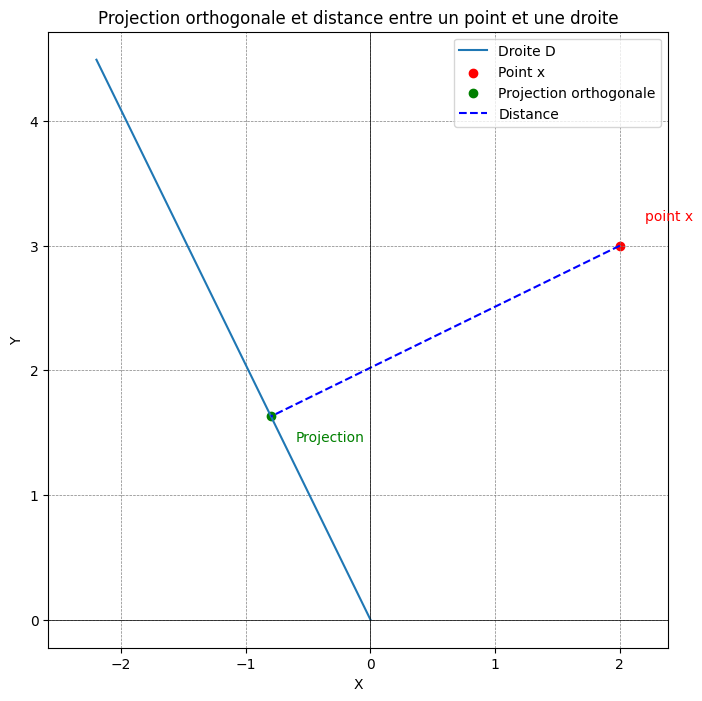

In [362]:
# Test de la fonction de projection orthogonale
x = Point(np.array([2, 3]))
D = Droite(Point(np.array([0,0])), np.array([-2.3, 4.7]))


# Calculer la projection orthogonale
projection = D.projection_orthogonale(x)
print("Coordonnées de la projection orthogonale:", projection)

# Calculer la distance entre le point et la droite
distance = D.distance_projection(x)
print("Distance entre le point et la droite:", distance)
plot_projection_distance(x, D)

In [363]:
# Fonction pour calculer la droite la plus proche d'un point
# x: un point de l'espace
# droites: un tableau de droites
# retourne le vecteur directeur de la droite la plus proche de x
def droite_plus_proche(x, droites):
    distances = [d.distance_projection(x) for d in droites]
    
    # Trouver l'indice de la droite la plus proche
    indice_plus_proche = np.argmin(distances)
    
    # Vérifier s'il y a des égalités de distance
    indices_egalite = np.where(distances == distances[indice_plus_proche])[0]
    
    # S'il y a des égalités, choisir aléatoirement parmi les droites équidistantes
    if len(indices_egalite) > 1:
        indice_plus_proche = np.random.choice(indices_egalite)
    
    return droites[indice_plus_proche], "Indice de la liste: {}".format(indice_plus_proche)

Distance entre le point et la droite: 3.1150920360380336


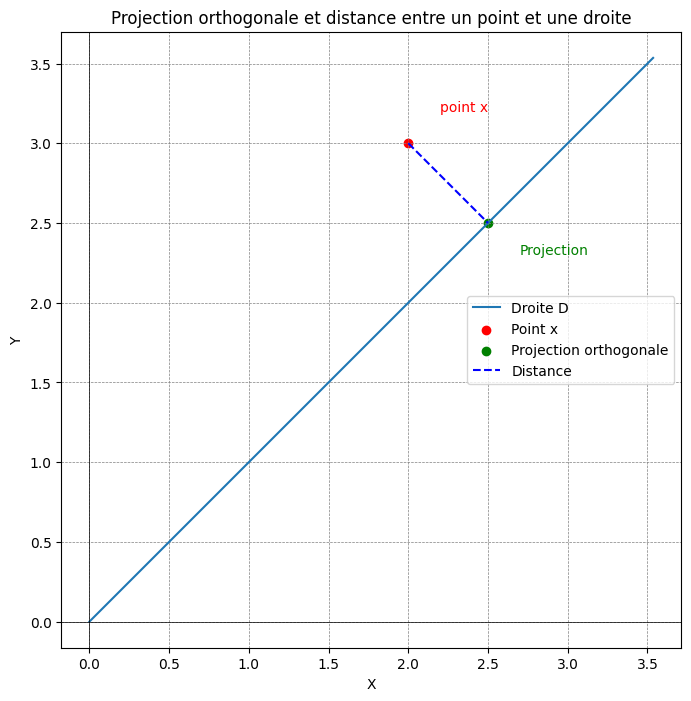

In [364]:
#Exemple avec deux droites
D2 = Droite(Point(np.array([0,0])), np.array([2, 2]))


# Calculer la distance entre le point et la droite
distance = D.distance_projection(x)
print("Distance entre le point et la droite:", distance)

plot_projection_distance(x, D2)


Déterminons maintenant la droite la plus proche du point $x$ parmi les deux droites $D1$ et $D2$.

In [365]:
print(droite_plus_proche(x, [D, D2]))

(Droite(Passe par le point Point([0 0]), vecteur directeur [0.70710678 0.70710678]), 'Indice de la liste: 1')


Le programme a bien déterminé que D2 est la droite la plus proche du point.

# Les nuées dynamiques ou les kmeans généralisés

L'algorithme des K-means permet de déterminer un nombre fixé de clusters dans un ensemble de points.
Il utilise la notion de représentant de classe et de distance entre un point et un représentant de classe.

Dans le cas des K-means standard, le représentant de la classe est un point de l'espace, tandis que la distance est la distance euclidienne.

Nous allons utiliser une généralisation de cet algorithme, où le représentant de la classe est une droite et la distance est la distance entre un point et une droite, donc la norme de la projection orthogonale. On définit alors l'algorithme des K-means généralisés.

In [366]:
# Créer un ensemble de droites représentant les K classes initiales
def initialiser_representants(K, points):
    dimension = points[0].dim()
    N = len(points)
    ind = np.linspace(0, N-1, K, dtype=int)
    representants = np.array([])
    for k in range(K):
        representants = np.append(representants, Droite(points[ind[k]], np.random.randn(dimension))) 
    return representants

# on veut uniquement les vecteurs propres de la matrice de covariance
def comp_acp(X):
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvecteurs = np.linalg.eigh(cov_matrix)
    # On trie les vecteurs propres par ordre décroissant des valeurs propres
    indices = np.argsort(eigenvalues)[::-1]
    eigenvecteurs = eigenvecteurs[:, indices]
    return eigenvecteurs


def kmeans_generalises(points, K, max_iterations=1000):
    # Initialisation des représentants (droites)
    representants = initialiser_representants(K, points)

    # Initialisation des classes précédentes
    prev_classes = np.zeros(len(points), dtype=int)

    for iteration in range(max_iterations):
        # Affectation des points aux classes
        distances = np.array([[representant.distance_projection(point) for representant in representants] for point in points]) # Matrice de distances de dimension (N, K)
        classes = np.argmin(distances, axis=1)  # Vecteur de classes de dimension (N,)

        # Vérifier si les classes ont convergé
        if np.array_equal(classes, prev_classes):
            #print(f"Convergence atteinte à l'itération {iteration + 1}")
            break  # Arrêter l'algorithme

        prev_classes = np.copy(classes)  # Mettre à jour les classes précédentes

        # Mise à jour des représentants
        for k in range(K):
            ind_k = np.where(classes == k)[0]
            X_k = np.array([points[i].coordonnées for i in ind_k]) # Sous matrice des points de la classe k
            # Si la classe pssède au moins 2 points
            if X_k.shape[0] > 1:
                acp_k = comp_acp(X_k)
                representants[k] = Droite(Point(np.mean(X_k, axis=0)), acp_k[0])
            # Sinon on garde le même représentant

    distances = np.array([[representant.distance_projection(point) for representant in representants] for point in points]) # Matrice de distances de dimension (N, K)
    classes = np.argmin(distances, axis=1)  # Vecteur de classes de dimension (N,)

    
    return representants, classes

# Exemples test

### Exemple 1

Nous allons tester l'algorithme sur un ensemble de points générés aléatoirement, suivant 2 droites dans $\mathbb{R}^2$. Il y aura donc 2 clusters:

Classe 1 - Représentant : Droite(Passe par le point Point([-0.76994908 -0.98267891]), vecteur directeur [-0.99979663 -0.02016653])
Classe 2 - Représentant : Droite(Passe par le point Point([0.76994908 0.98267891]), vecteur directeur [-0.99980555 -0.01971938])


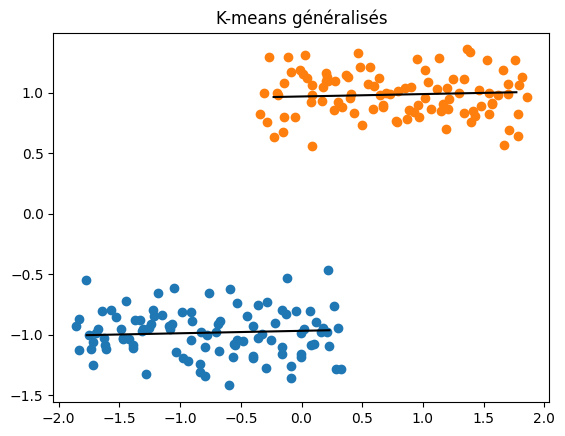

In [367]:
# Définir trois droites
def droite1(x):
    return 0

def droite2(x):
    return 10

# def droite3(x):
#     return x - 500

# Points autour de la première droite
X1, _ = make_blobs(n_samples=100, centers=[[i, droite1(i) + np.random.normal(0, 0.25)] for i in range(-100, 70)])

# Points autour de la deuxième droite
X2, _ = make_blobs(n_samples=100, centers=[[i, droite2(i) + np.random.normal(0, 0.25)] for i in range(-30, 100)])

# # Points autour de la troisième droite
# X3, _ = make_blobs(n_samples=100, centers=[[i, droite3(i) + np.random.normal(0, 0.25)] for i in range(-50, 50)])

# Concaténer les points pour former un ensemble de données
data = np.concatenate([X1, X2])

# Normaliser les données
data = StandardScaler().fit_transform(data)

# Appliquer l'algorithme des k-means généralisés 10 fois et choisir le résultat avec le moins d'erreur
K = 2

liste_representants = []
liste_classes = []
trueclass = np.concatenate([np.zeros(100), np.ones(100)])
for i in range(10):
    representants, classes = kmeans_generalises([Point(coord) for coord in data], K, max_iterations=100)
    liste_representants.append(representants)
    liste_classes.append(classes)
representants = liste_representants[np.argmin([np.sum(np.abs(classes - trueclass)) for classes in liste_classes])]
classes = liste_classes[np.argmin([np.sum(np.abs(classes - trueclass)) for classes in liste_classes])]


# Afficher les résultats
for i in range(K):
    print(f"Classe {i + 1} - Représentant : {representants[i]}")

# Afficher les points en couleur en fonction des classes
for k in range(K):
    ind_k = np.where(classes == k)[0]
    points_k = data[ind_k]
    plt.scatter(points_k[:, 0], points_k[:, 1], label=f'Classe {k + 1}')

# Afficher les droites des représentants
for i in range(K):
    droite = representants[i]

    # Tracer la droite
    direction = droite.vecteur
    centre = droite.point.coordonnées
    scale = 1
    origin = centre - scale * direction
    end_point = centre + scale * direction
    plt.plot([origin[0], end_point[0]], [origin[1], end_point[1]], color='black')

# x_values = np.arange(20)
# plt.plot(x_values, [droite1(i) for i in x_values], color='red', linestyle='dashed', label='Droite 1 réelle')
# plt.plot(x_values, [droite2(i) for i in x_values], color='green', linestyle='dashed', label='Droite 2 réelle')
# plt.plot(x_values, [droite3(i) for i in x_values], color='blue', linestyle='dashed', label='Droite 3 réelle')

plt.title('K-means généralisés')
plt.show()

### Exemple 2

Nous allons tester l'algorithme sur un ensemble de points générés aléatoirement, suivant 3 droites dans $\mathbb{R}^2$. Il y aura donc 3 clusters.
Vérifions également qu'avec cette génération, l'algorithme des K-means standard ne fonctionne pas, et que l'algorithme des K-means généralisés fonctionne.

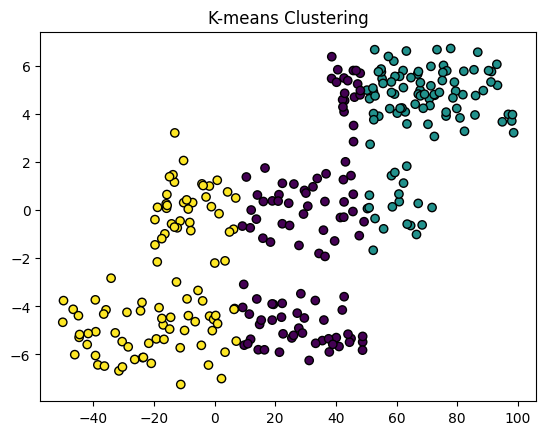

Classe 1 - Représentant : Droite(Passe par le point Point([-0.26067965 -4.96908009]), vecteur directeur [-9.99999601e-01  8.93497685e-04])
Classe 2 - Représentant : Droite(Passe par le point Point([20.87422751  0.05733129]), vecteur directeur [-0.99999576  0.0029108 ])
Classe 3 - Représentant : Droite(Passe par le point Point([64.49809419  4.92214836]), vecteur directeur [-9.99999881e-01  4.88320677e-04])


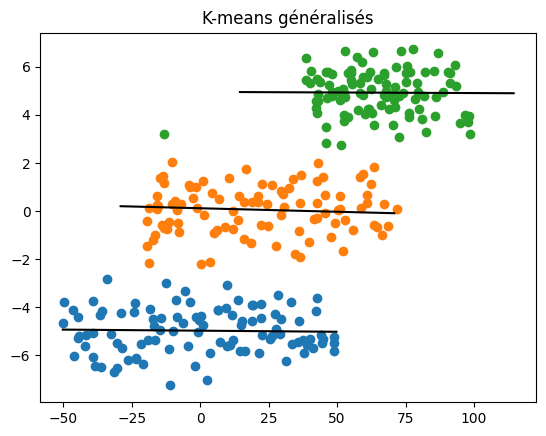

In [368]:
# Définir trois droites
def droite1(x):
    return -5

def droite2(x):
    return 0

def droite3(x):
    return 5

# Points autour de la première droite
X1, _ = make_blobs(n_samples=100, centers=[[i, droite1(i) + np.random.normal(0, 0.01)] for i in range(-50, 50)])

# Points autour de la deuxième droite
X2, _ = make_blobs(n_samples=100, centers=[[i, droite2(i) + np.random.normal(0, 0.01)] for i in range(-20, 70)])

# Points autour de la troisième droite
X3, _ = make_blobs(n_samples=100, centers=[[i, droite3(i) + np.random.normal(0, 0.01)] for i in range(40, 100)])

# Concaténer les points pour former un ensemble de données
data = np.concatenate([X1, X2, X3])

# Normaliser les données
data_normalized = StandardScaler().fit_transform(data)

# Appliquer l'algorithme K-means
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans_labels = kmeans.fit_predict(data)


plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k')
plt.title('K-means Clustering')
plt.show()

# Appliquer l'algorithme des k-means généralisés 10 fois et choisir le résultat avec le moins d'erreur
K = 3

liste_representants = []
liste_classes = []
trueclass = np.concatenate([np.zeros(100), np.ones(100), 2*np.ones(100)])
for i in range(10):
    representants, classes = kmeans_generalises([Point(coord) for coord in data], K, max_iterations=100)
    liste_representants.append(representants)
    liste_classes.append(classes)
representants = liste_representants[np.argmin([np.sum(np.abs(classes - trueclass)) for classes in liste_classes])]
classes = liste_classes[np.argmin([np.sum(np.abs(classes - trueclass)) for classes in liste_classes])]

# Afficher les résultats
for i in range(K):
    print(f"Classe {i + 1} - Représentant : {representants[i]}")

# Afficher les points en couleur en fonction des classes
for k in range(K):
    ind_k = np.where(classes == k)[0]
    points_k = data[ind_k]
    plt.scatter(points_k[:, 0], points_k[:, 1], label=f'Classe {k + 1}')

# Afficher les droites des représentants
for i in range(K):
    droite = representants[i]

    # Tracer la droite
    direction = droite.vecteur
    centre = droite.point.coordonnées
    scale = 50
    origin = centre - scale * direction
    end_point = centre + scale * direction
    plt.plot([origin[0], end_point[0]], [origin[1], end_point[1]], color='black')

# x_values = np.arange(20)
# plt.plot(x_values, [droite1(i) for i in x_values], color='red', linestyle='dashed', label='Droite 1 réelle')
# plt.plot(x_values, [droite2(i) for i in x_values], color='green', linestyle='dashed', label='Droite 2 réelle')
# plt.plot(x_values, [droite3(i) for i in x_values], color='blue', linestyle='dashed', label='Droite 3 réelle')

plt.title('K-means généralisés')
plt.show()

On remarque que pour ce dataset, la méthode de K-means généralisée est plus efficace que la méthode de K-means classique. En effet, la méthode classique ne permet pas de séparer les 3 nuées de points.

# Application au dataset iris

Nous allons dans cette partie tester notre algorithme des K-means généralisés sur le dataset $iris$ et le comparer à deux autres modèles de clustering classiques, à savoir les K-means classiques et un modèle de mélange gaussien.

Dans un premier lieu, voici une représentation du dataset en 2 dimensions à l'aide d'une Analyse en Composantes Principales, avec chaque cluster représenté d'une couleur différente :

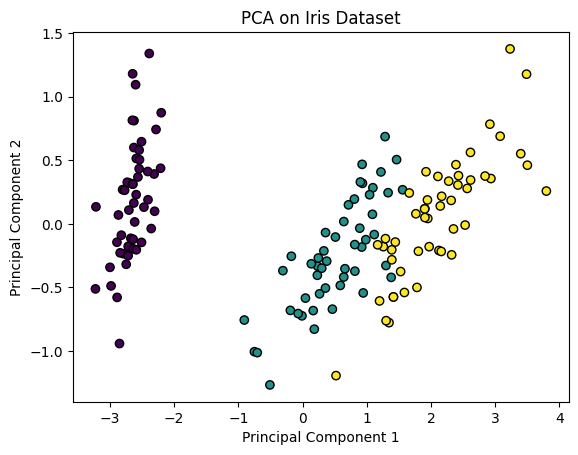

In [369]:
# Charger le jeu de données Iris
iris = datasets.load_iris()
X = iris.data
y = iris.target

# ACP pour visualiser les données en 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k', cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Iris Dataset')
plt.show()

Nous observons qu'il y a exactement 3 clusters, ayant chacun une tendance de dispersion assez linéaire, et dont 2 sont assez proches l'un de l'autre. Voyons donc maintenant ce que les différentes méthodes de clustering donnent comme résultats.

Voici une visualisation des différents clustering :

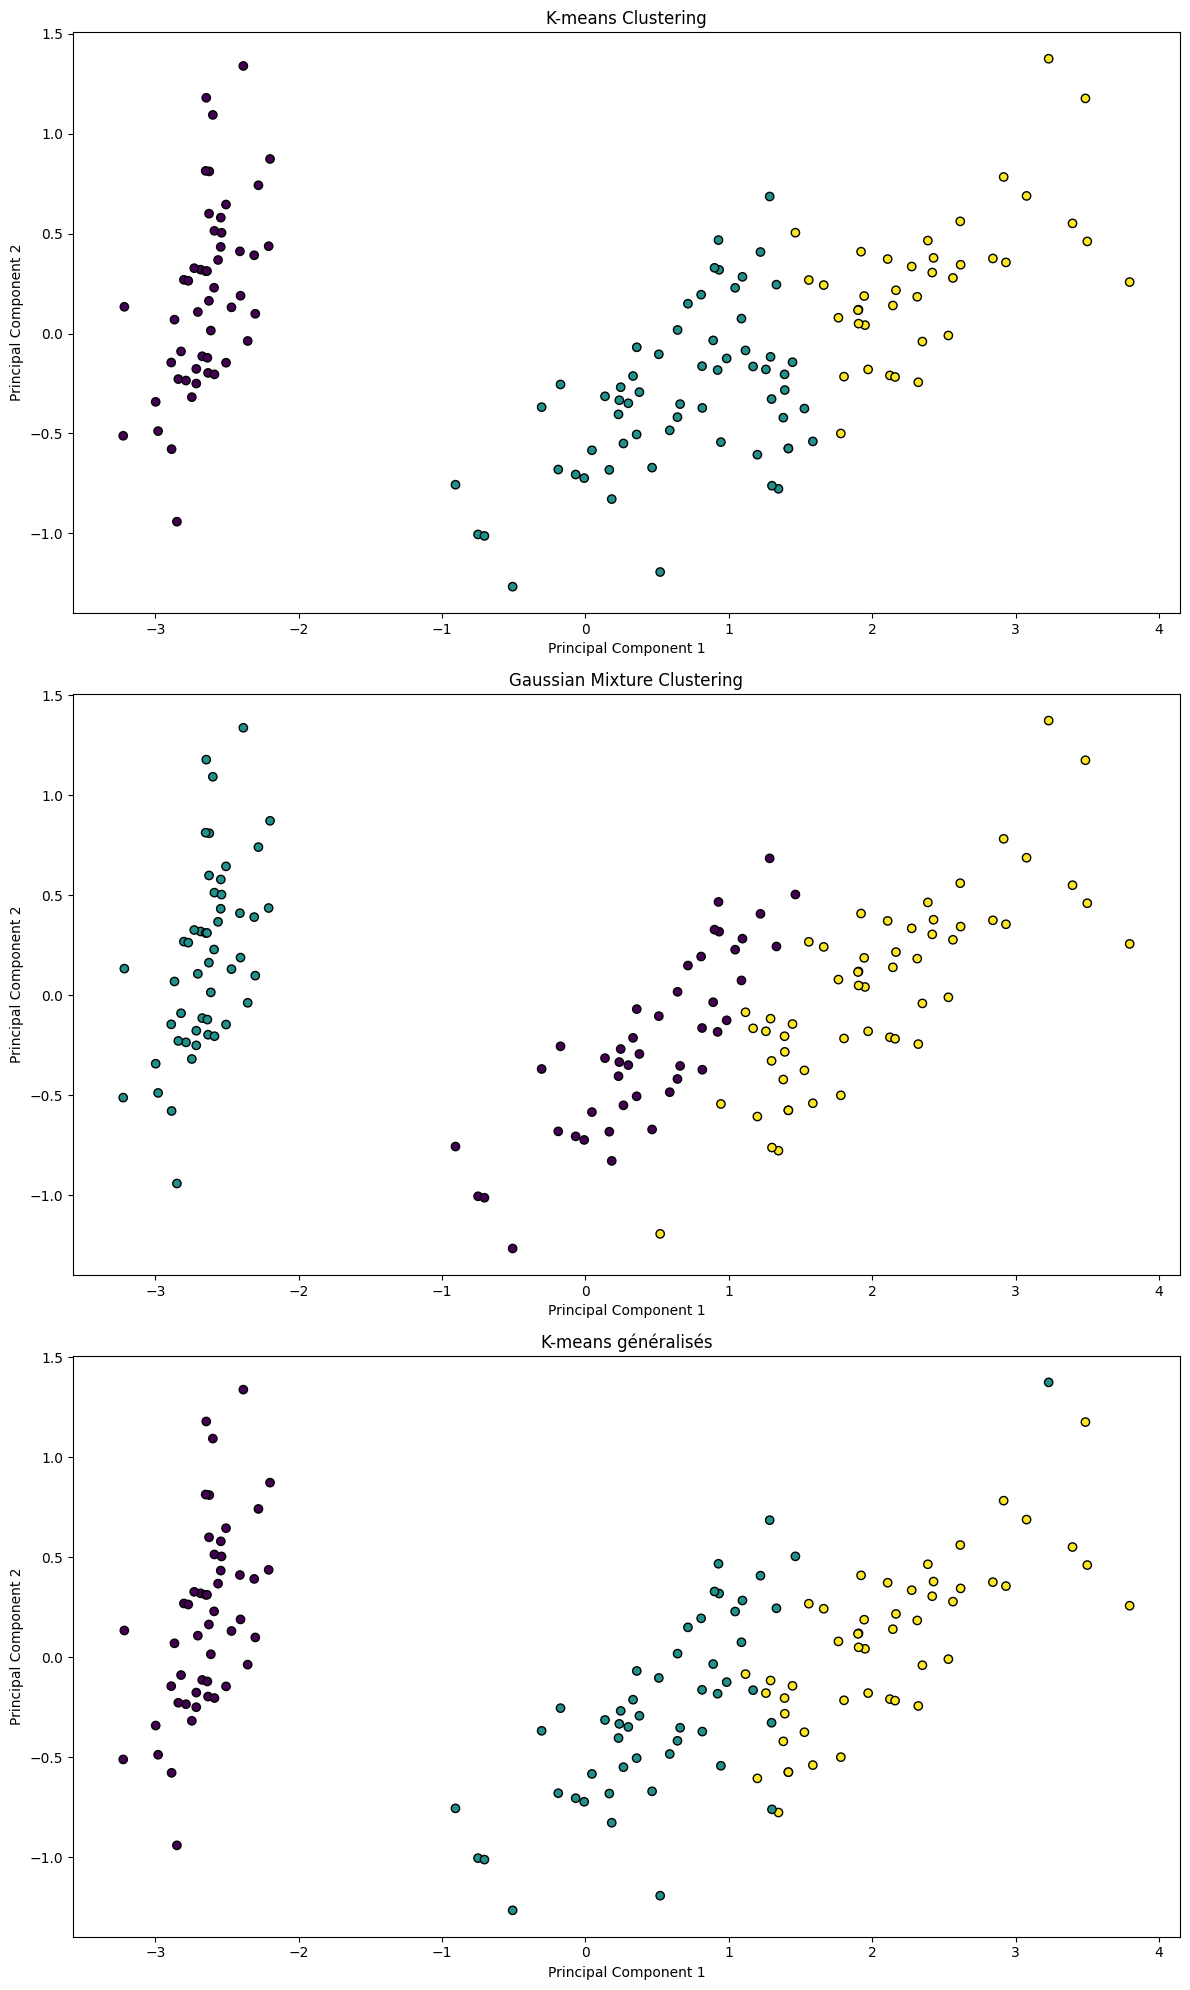

In [383]:
# Appliquer l'algorithme K-means
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Appliquer l'algorithme de mélange gaussien
gmm = GaussianMixture(n_components=3)
gmm_labels = gmm.fit_predict(X)

# Appliquer l'algorithme des k-means généralisés 10 fois et choisir le résultat avec le moins d'erreur
K = 3
liste_representants = []
liste_classes = []
for i in range(10):
    representants, classes = kmeans_generalises([Point(coord) for coord in X], K, max_iterations=100)
    liste_representants.append(representants)
    liste_classes.append(classes)
representants = liste_representants[np.argmin([np.sum(np.abs(classes - y)) for classes in liste_classes])]
classes = liste_classes[np.argmin([np.sum(np.abs(classes - y)) for classes in liste_classes])]


# Comparaison des méthodes
# Tracer les points avec les couleurs des clusters attribuées par K-means
plt.figure(figsize=(12, 20))

plt.subplot(3, 1, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k')
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Tracer les points avec les couleurs des clusters attribuées par le mélange gaussien
plt.subplot(3, 1, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', edgecolor='k')
plt.title('Gaussian Mixture Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Tracer les points avec les couleurs des clusters attribuées par K-means généralisés
plt.subplot(3, 1, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=classes, cmap='viridis', edgecolor='k')
plt.title('K-means généralisés')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

Et voici leur puissance prédictive respective :

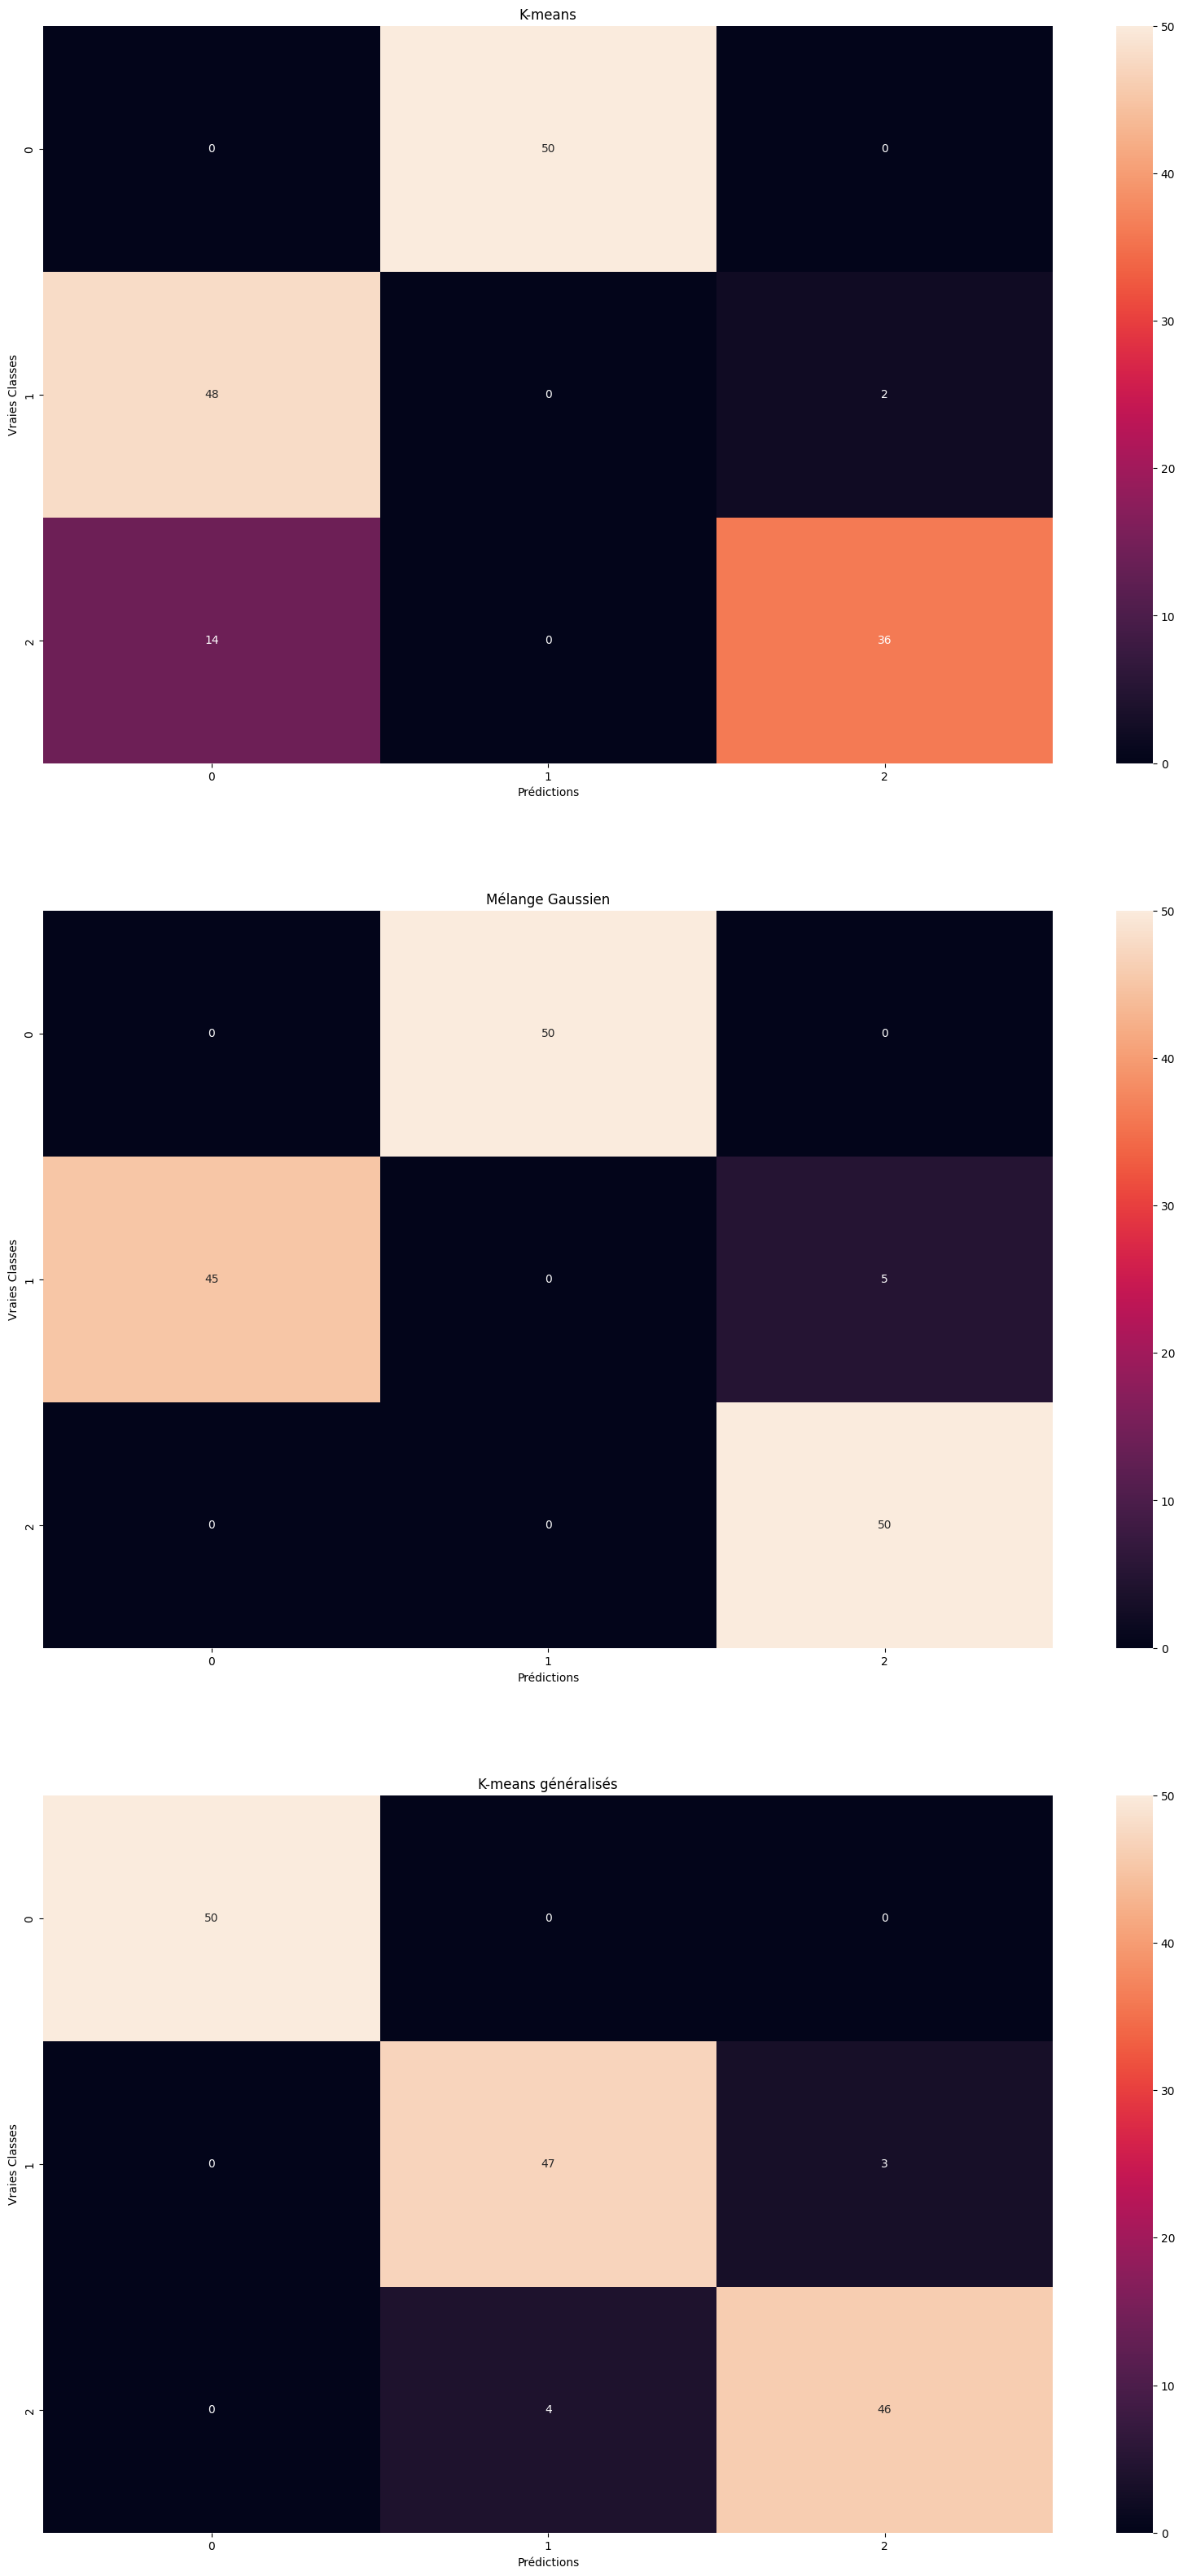

In [381]:
# Calculer la matrice de confusion
matrice_confusion_kmeans = confusion_matrix(iris.target, kmeans_labels)
matrice_confusion_gmm = confusion_matrix(iris.target, gmm_labels)
matrice_confusion_kmeans_generalises = confusion_matrix(iris.target, classes)


plt.figure(figsize=(20, 40))

plt.subplot(3, 1, 1)
sns.heatmap(matrice_confusion_kmeans, annot=True, fmt="d")
plt.title('K-means')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Classes')

plt.subplot(3, 1, 2)
sns.heatmap(matrice_confusion_gmm, annot=True, fmt="d")
plt.title('Mélange Gaussien')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Classes')

plt.subplot(3, 1, 3)
sns.heatmap(matrice_confusion_kmeans_generalises, annot=True, fmt="d")
plt.title('K-means généralisés')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Classes')

plt.show()

On observe donc que les deux versions des K-means sont assez précises, environ 90% pour le classique, et 94% pour le généralisé.

Cependant, le modèle de mélange gaussien est beaucoup plus précis, puisque seulement 5 fleurs sont mal classées, soit une précision de 96,6% !

Ceci pourrait s'expliquer par le fait que les algorithmes de K-means sont très sensibles à l'initialisation des clusters, qui sont déterminants.